# Click-Through Rate Prediction
### We use data of mobile ads to predict click-through rate
### data source: https://www.kaggle.com/c/avazu-ctr-prediction

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 100)

import numpy as np
np.random.seed(0)
import random
random.seed(0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

### Sample 2 million data points from the original ~6G dataset:

In [3]:

n_train = 40428967  # total number of records in the training set
n_sample = 2000000
skipped_rows = sorted(random.sample(range(1, n_train), n_train - n_sample))

## define data type for training and test sets:
types_train = {
    'id': np.dtype(int), 'click': np.dtype(int), 'hour': np.dtype(int), 'C1': np.dtype(int),
    'banner_pos': np.dtype(int),'site_id': np.dtype(str), 'site_domain': np.dtype(str),
    'site_category': np.dtype(str), 'app_id': np.dtype(str), 'app_domain': np.dtype(str),
    'app_category': np.dtype(str), 'device_id': np.dtype(str), 'device_ip': np.dtype(str),
    'device_model': np.dtype(str), 'device_type': np.dtype(int), 'device_conn_type': np.dtype(int),
    'C14': np.dtype(int), 'C15': np.dtype(int), 'C16': np.dtype(int), 'C17': np.dtype(int), 
    'C18': np.dtype(int), 'C19': np.dtype(int), 'C20': np.dtype(int), 'C21':np.dtype(int)
}

types_test = { key:val for (key,val) in types_train.items() if key!= 'click'}

### Load data:

In [4]:
import gzip

get_date = lambda s : pd.datetime.strptime(s, '%y%m%d%H')

with gzip.open('./data/CTR_train.gz') as f:
    train_df = pd.read_csv(f, parse_dates = ['hour'], date_parser = get_date,
                         dtype = types_train, skiprows = skipped_rows)

train_df.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10004574413841529209,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,-1,79
1,10009147085943364421,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,17037,320,50,1934,2,39,-1,16


In [5]:
train_df.dtypes

id                          uint64
click                        int64
hour                datetime64[ns]
C1                           int64
banner_pos                   int64
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  int64
device_conn_type             int64
C14                          int64
C15                          int64
C16                          int64
C17                          int64
C18                          int64
C19                          int64
C20                          int64
C21                          int64
dtype: object

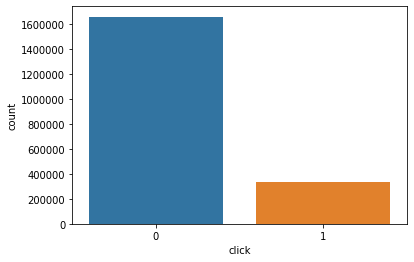

In [6]:
sns.countplot(x='click',data=train_df)
plt.show()

In [7]:
print(train_df['click'].value_counts())
print(train_df['click'].value_counts()/len(train_df))

0    1661688
1     338312
Name: click, dtype: int64
0    0.830844
1    0.169156
Name: click, dtype: float64


Text(0.5, 1.0, 'Number of clicks by hour')

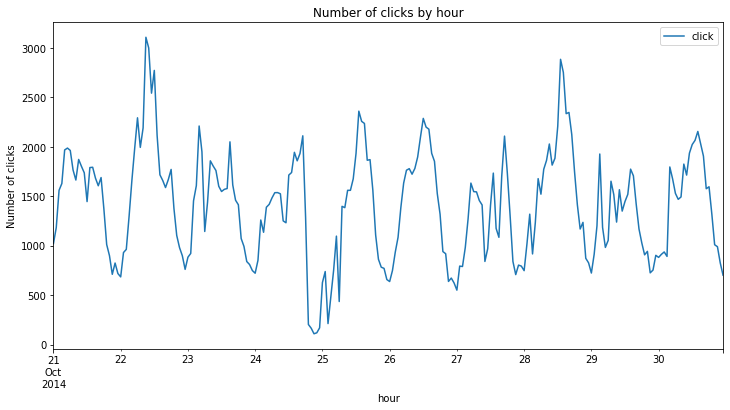

In [8]:
#sns.countplot(x='int_hour',data=train_df)
train_df.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour')

In [9]:
#train_df.dtypes

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
## add features: 'hour_of_day' and 'day_of_week'
train_df['hour_of_day'] = train_df['hour'].apply(lambda t: t.hour)
train_df['day_of_week'] = train_df['hour'].apply(lambda t: t.weekday_name)

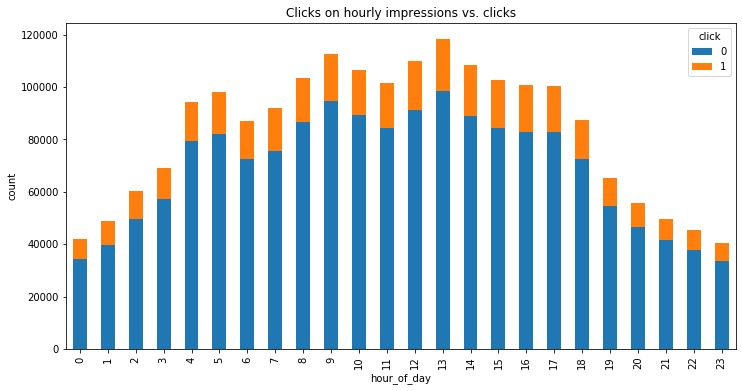

In [12]:
train_df.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar',stacked=True, title="Hour of the Day", figsize=(12,6))

#train_df.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar',stacked=True, title="Hour of the Day", figsize=(12,6))

plt.ylabel('count')
plt.title('Clicks on hourly impressions vs. clicks');

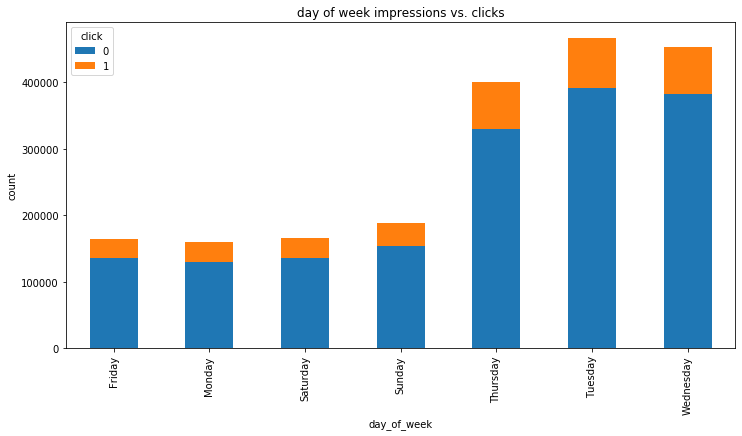

In [13]:
train_df.groupby(['day_of_week', 'click']).size().unstack().plot(kind='bar',stacked=True, title="Day of the week", figsize=(12,6))

#train_df.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar',stacked=True, title="Hour of the Day", figsize=(12,6))

plt.ylabel('count')
plt.title('day of week impressions vs. clicks');

Text(0.5, 0, 'C1 domain')

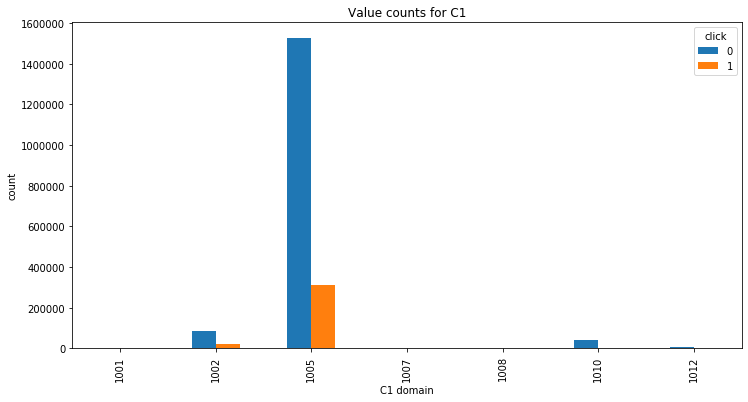

In [14]:
train_df.groupby(['C1', 'click']).size().unstack().plot(kind='bar', title="Value counts for C1", figsize=(12,6))
plt.ylabel('count')
plt.xlabel('C1 domain')

Text(0.5, 0, 'banner_pos')

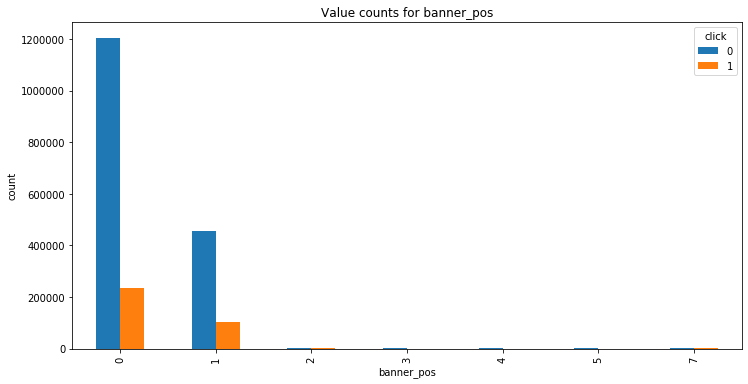

In [15]:
train_df.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', title="Value counts for banner_pos", figsize=(12,6))
plt.ylabel('count')
plt.xlabel('banner_pos')

Text(0.5, 0, 'site_category')

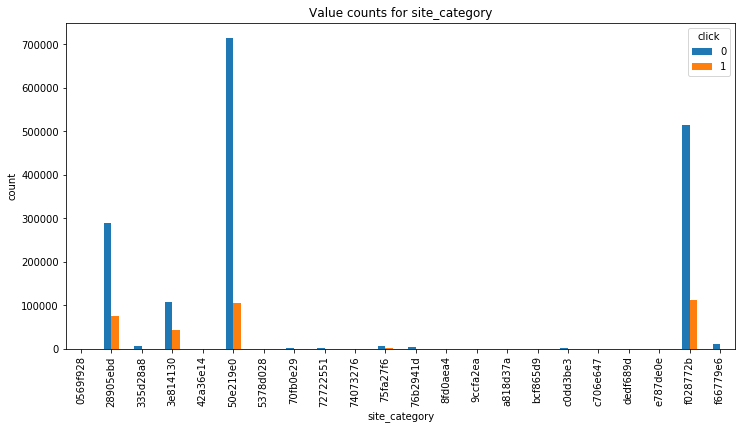

In [16]:
train_df.groupby(['site_category', 'click']).size().unstack().plot(kind='bar', title="Value counts for site_category", figsize=(12,6))
plt.ylabel('count')
plt.xlabel('site_category')

Text(0.5, 0, 'app_category')

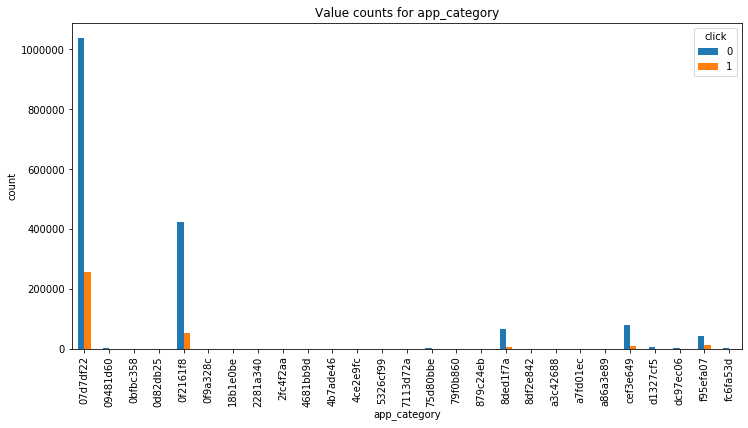

In [17]:
train_df.groupby(['app_category', 'click']).size().unstack().plot(kind='bar', title="Value counts for app_category", figsize=(12,6))
plt.ylabel('count')
plt.xlabel('app_category')

Text(0.5, 0, 'device_type')

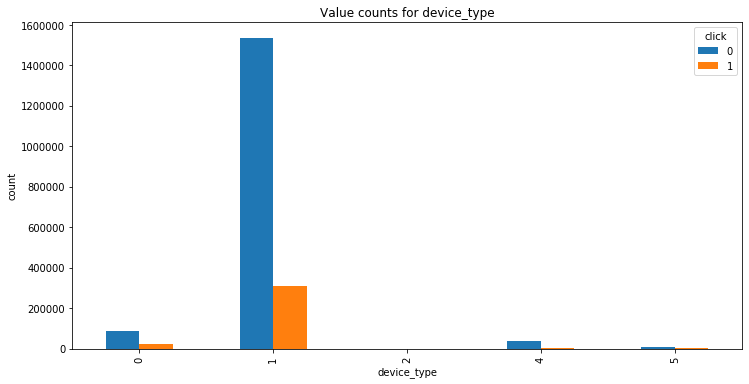

In [18]:
train_df.groupby(['device_type', 'click']).size().unstack().plot(kind='bar', title="Value counts for device_type", figsize=(12,6))
plt.ylabel('count')
plt.xlabel('device_type')

In [19]:
#train_df.groupby(['device_id', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Value counts for device_id", figsize=(12,6))
#plt.ylabel('count')
#plt.xlabel('device_id')

In [20]:
#train_df.groupby(['device_ip', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Value counts for device_ip", figsize=(12,6))
#plt.ylabel('count')
#plt.xlabel('device_ip')

Text(0.5, 0, 'device_conn_type')

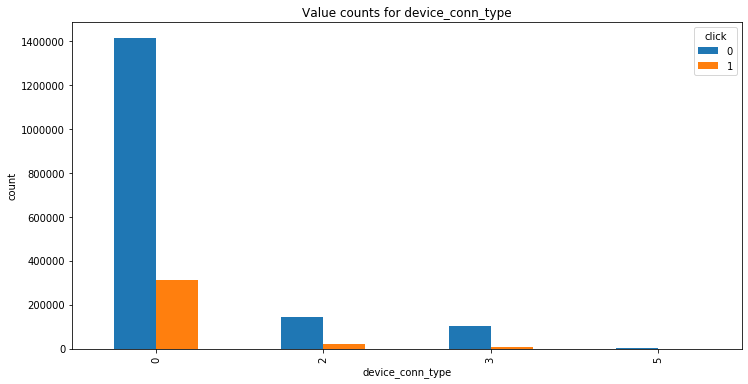

In [21]:
train_df.groupby(['device_conn_type', 'click']).size().unstack().plot(kind='bar', title="Value counts for device_conn_type", figsize=(12,6))
plt.ylabel('count')
plt.xlabel('device_conn_type')

C15
C16
C18
C19
C21


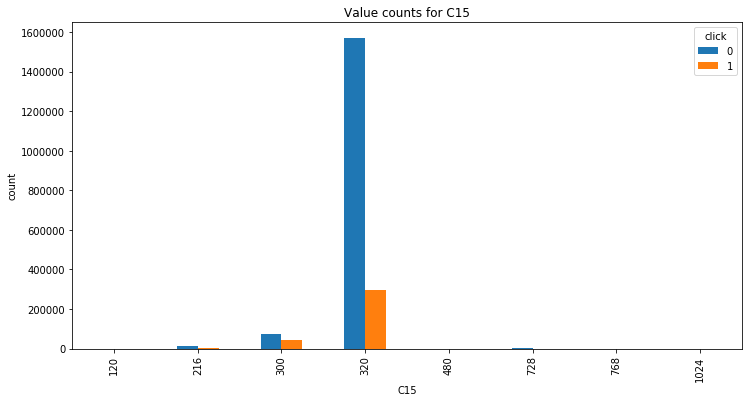

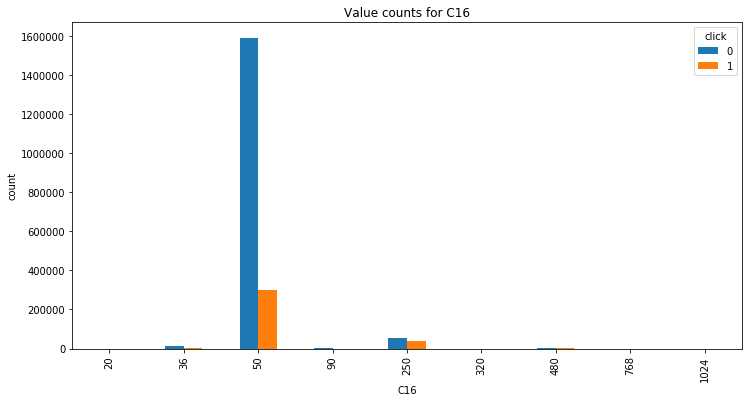

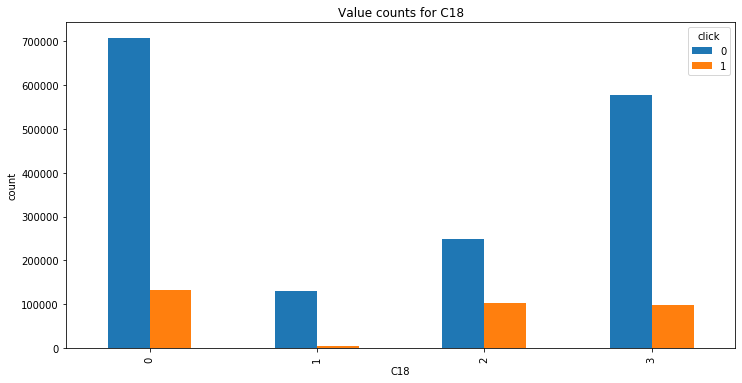

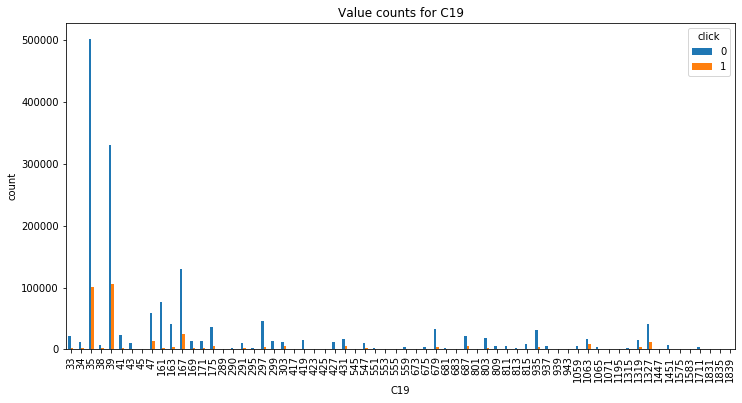

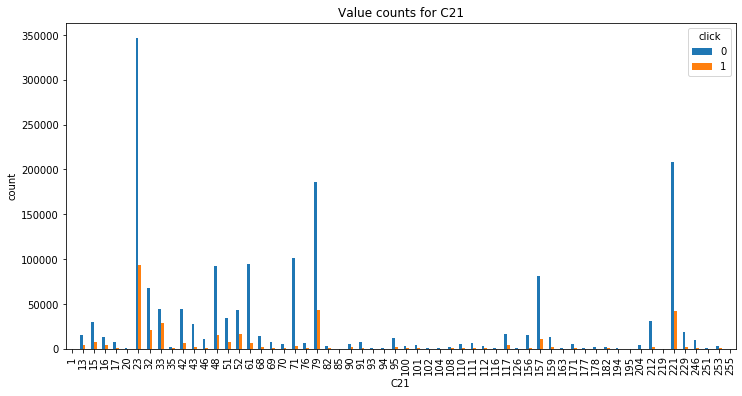

In [22]:
features = ['C15', 'C16', 'C18', 'C19', 'C21']
for feature in features:
    print(feature)
    train_df.groupby([feature, 'click']).size().unstack().plot(kind='bar', title='Value counts for '+feature, figsize=(12,6))
    plt.ylabel("count")
    plt.xlabel(feature)

In [23]:
train_df.drop('id', axis=1, inplace=True)
train_df.drop('hour', axis=1, inplace=True)

In [24]:
columns = list(train_df.columns)

for c in columns:
    #print("For column " + c + ", number of unique value: ", train_df[c].value_counts())
    print("For column " + c + ", number of unique value: ", train_df[c].nunique())

For column click, number of unique value:  2
For column C1, number of unique value:  7
For column banner_pos, number of unique value:  7
For column site_id, number of unique value:  3019
For column site_domain, number of unique value:  3493
For column site_category, number of unique value:  22
For column app_id, number of unique value:  3990
For column app_domain, number of unique value:  260
For column app_category, number of unique value:  27
For column device_id, number of unique value:  278354
For column device_ip, number of unique value:  962845
For column device_model, number of unique value:  5748
For column device_type, number of unique value:  5
For column device_conn_type, number of unique value:  4
For column C14, number of unique value:  2371
For column C15, number of unique value:  8
For column C16, number of unique value:  9
For column C17, number of unique value:  424
For column C18, number of unique value:  4
For column C19, number of unique value:  66
For column C20, n

In [ ]:
## in the original 6G data, there are total 40428967 samples including:
## click == 1: 6865066
## click == 0: 33563901

In [25]:
## define funtion to check column 0-1 distribution:
#train_df.query("click == 0")['device_id'].value_counts()

def col_01_check(col_name):
    tmp_0 = train_df.query("click == 1")[col_name].value_counts()
    tmp_1 = train_df.query("click == 0")[col_name].value_counts()
    tmp_count = pd.concat([tmp_0, tmp_1], axis=1, sort=False)
    tmp_count.columns = [col_name+'_0_count', col_name+'_1_count']
    print(tmp_count)

In [26]:
col_01_check('site_category')
col_01_check('device_id')
col_01_check('device_ip')

          site_category_0_count  site_category_1_count
f028772b               111873.0                 513646
50e219e0               105115.0                 713923
28905ebd                75548.0                 289112
3e814130                42361.0                 108213
75fa27f6                  959.0                   7176
335d28a8                  612.0                   6304
dedf689d                  611.0                    630
f66779e6                  516.0                  11859
c0dd3be3                  231.0                   1871
70fb0e29                  171.0                   1052
76b2941d                  154.0                   4945
72722551                   75.0                   1327
0569f928                   46.0                    845
42a36e14                   27.0                    101
e787de0e                    5.0                     60
8fd0aea4                    4.0                    357
a818d37a                    2.0                    171
5378d028  

In [27]:
def hash_columns(self):
    
    list_columns = self.columns
    new_col_suffix = '_int'
    for i in range(0,len(list_columns)):
        if list_columns[i] == 'click': continue
        self[list_columns[i]+new_col_suffix] = self[list_columns[i]].map( lambda  x: hash(str(x)) )
        self.drop([list_columns[i]],inplace=True,axis=1)
    return self

In [28]:
train_df = hash_columns(train_df)

In [29]:
train_df.head(5)

,click,C1_int,banner_pos_int,site_id_int,site_domain_int,site_category_int,app_id_int,app_domain_int,app_category_int,device_id_int,...,C14_int,C15_int,C16_int,C17_int,C18_int,C19_int,C20_int,C21_int,hour_of_day_int,day_of_week_int
0,0,-8700979718979901392,163995104590789672,-6445353404058689253,5383995932796404068,1515261379283315779,-8345816819388695176,1253367739737239422,8737622695160917951,-791536577758330075,...,4042450328897438682,-1042067531008778602,2173298622108858861,4578800058284398511,163995104590789672,-6037458485118174614,6176901992623594943,4708882737264407643,163995104590789672,4109544624077499863
1,0,-8700979718979901392,8995045209798467750,588902103741954180,-5461776723329727809,-3895400793981642817,-8345816819388695176,1253367739737239422,8737622695160917951,-791536577758330075,...,4021181798103863399,-1042067531008778602,2173298622108858861,-6339577183387558849,-3523885315555872262,-2737866056422511125,6176901992623594943,4044547285224662320,163995104590789672,4109544624077499863
2,0,-8700979718979901392,163995104590789672,-9204550599453455189,986187297040842563,-3448777302167245598,-4918141856249059845,-1898180666840457749,-1160196441956768306,-791536577758330075,...,-6549110817387194282,-1042067531008778602,2173298622108858861,3352877044202970570,163995104590789672,-6037458485118174614,6176901992623594943,7759683943776936363,163995104590789672,4109544624077499863
3,0,-8700979718979901392,163995104590789672,-6445353404058689253,5383995932796404068,1515261379283315779,-8345816819388695176,1253367739737239422,8737622695160917951,-791536577758330075,...,2537582312066194044,-1042067531008778602,2173298622108858861,4578800058284398511,163995104590789672,-6037458485118174614,6176901992623594943,4708882737264407643,163995104590789672,4109544624077499863
4,1,-8700979718979901392,163995104590789672,-6445353404058689253,5383995932796404068,1515261379283315779,-8345816819388695176,1253367739737239422,8737622695160917951,-791536577758330075,...,-2600651802547419560,-1042067531008778602,2173298622108858861,4578800058284398511,163995104590789672,-6037458485118174614,-7292267443241388203,4708882737264407643,163995104590789672,4109544624077499863


In [30]:
train_df.dtypes

click                   int64
C1_int                  int64
banner_pos_int          int64
site_id_int             int64
site_domain_int         int64
site_category_int       int64
app_id_int              int64
app_domain_int          int64
app_category_int        int64
device_id_int           int64
device_ip_int           int64
device_model_int        int64
device_type_int         int64
device_conn_type_int    int64
C14_int                 int64
C15_int                 int64
C16_int                 int64
C17_int                 int64
C18_int                 int64
C19_int                 int64
C20_int                 int64
C21_int                 int64
hour_of_day_int         int64
day_of_week_int         int64
dtype: object

In [31]:
#X_train = train_df.drop('click', axis=1)
#Y_train = train_df.click
#X_train.dtypes

pre_X = train_df.loc[:, train_df.columns != 'click']
pre_Y = train_df.click.values

In [32]:
pre_X.head(2)

,C1_int,banner_pos_int,site_id_int,site_domain_int,site_category_int,app_id_int,app_domain_int,app_category_int,device_id_int,device_ip_int,...,C14_int,C15_int,C16_int,C17_int,C18_int,C19_int,C20_int,C21_int,hour_of_day_int,day_of_week_int
0,-8700979718979901392,163995104590789672,-6445353404058689253,5383995932796404068,1515261379283315779,-8345816819388695176,1253367739737239422,8737622695160917951,-791536577758330075,-6567236904294202756,...,4042450328897438682,-1042067531008778602,2173298622108858861,4578800058284398511,163995104590789672,-6037458485118174614,6176901992623594943,4708882737264407643,163995104590789672,4109544624077499863
1,-8700979718979901392,8995045209798467750,588902103741954180,-5461776723329727809,-3895400793981642817,-8345816819388695176,1253367739737239422,8737622695160917951,-791536577758330075,-5058168579088681667,...,4021181798103863399,-1042067531008778602,2173298622108858861,-6339577183387558849,-3523885315555872262,-2737866056422511125,6176901992623594943,4044547285224662320,163995104590789672,4109544624077499863


In [ ]:
## train-test split: reserve 20% for testing
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test =  train_test_split(preX, preY, test_size = 0.2, random_state=0)

In [33]:
import lightgbm as lgb

#create lightgbm dataset
mask = np.random.rand(len(pre_X)) < 0.8

train_X, train_Y = pre_X[mask], pre_Y[mask]
test_X, test_Y = pre_X[~mask], pre_Y[~mask]

In [34]:
lgb_train = lgb.Dataset(train_X, train_Y)
lgb_test = lgb.Dataset(test_X, test_Y, reference = lgb_train)

In [35]:
## model parameters:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 50, # default leave amount for each tree
    'learning_rate': 0.05,
    'feature_fraction': 0.7, # will select 70% features before training each tree
    #'bagging_fraction': 0.3, #feature_fraction, but this will random select part of data
    #'bagging_freq': 5, #  perform bagging at every 5 iteration
    'verbose': 1
}
# valid_sets = [valid_set, train_set], valid_names = [‘eval’, ‘train’]

# model training:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets  = [lgb_train, lgb_test],
                valid_names = ['train', 'eval'],
                early_stopping_rounds=500,
                verbose_eval = 1000)


Training until validation scores don't improve for 500 rounds.
[1000]	train's binary_logloss: 0.388799	eval's binary_logloss: 0.396768
[2000]	train's binary_logloss: 0.380355	eval's binary_logloss: 0.395557
[3000]	train's binary_logloss: 0.373362	eval's binary_logloss: 0.395122
[4000]	train's binary_logloss: 0.367136	eval's binary_logloss: 0.394984
Early stopping, best iteration is:
[4161]	train's binary_logloss: 0.366204	eval's binary_logloss: 0.39498


In [ ]:
#print(gbm.best_score)
#print(gbm.best_iteration)

In [36]:
#type(lgb_test)
pred_prob = gbm.predict(test_X)
pred = pred_prob > 0.5
print(sum(pred)/len(pred))

0.02245683635664124


In [37]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

In [38]:
# calculate accuracy, precision and recall
def compute_scores(conf_matrix):
    
    tn, fp, fn, tp = conf_matrix[0][0], conf_matrix[0][1], conf_matrix[1][0], conf_matrix[1][1]
    
    accuracy  = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    #print ("Accuracy is: %0.3f" % accuracy)
    #print ("precision is: %0.3f" % precision)
    #print ("recall is: %0.3f" % recall)
    return accuracy, precision, recall

conf_matrix = confusion_matrix(test_Y, pred)
a, p, r = compute_scores(conf_matrix)
print(f"Accuracy: {a}")
print(f"Precision: {p}")
print(f"Recall: {r}")
print("AUC is: ", roc_auc_score(test_Y, pred_prob))

Accuracy: 0.8353523417416352
Precision: 0.6170875514517744
Recall: 0.0815615350683723
AUC is:  0.7523369145471521


In [39]:

# define function for plotting curve:
def plot_curve(model_name, x, name1, y1, name2, y2, name3, y3):
    plt.plot(x, y1, lw = 2, label = name1)
    plt.plot(x, y2, lw = 2, label = name2 )
    plt.plot(x, y3, lw = 2, label = name3)
    plt.xlabel('Model threshold')
    plt.ylabel('Model score')
    plt.title('Model score vs threshold for ' + model_name)
    plt.legend(loc='lower center')
    plt.xlim([-0.05, 1.05])
    return

## compute fpr, tpr and threshold:
#fpr, tpr, thresh = roc_curve(test_Y, pred_prob)

#print(f"how many threshold value is used: {len(thresh)}")

In [40]:
thresh = np.asarray(np.arange(0.0, 1.0, 0.005))

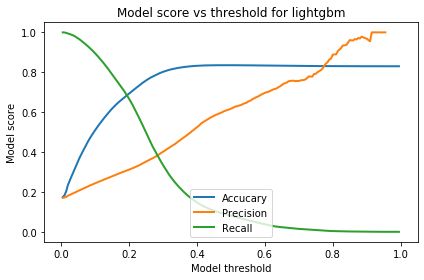

In [41]:

## compute probability of positive case and prediction:
pred_prob = gbm.predict(test_X)

## initialize accuracy, precision and recall:
accuracy, precision, recall = [], [], []

for j in range(len(thresh)):
    pred = pred_prob >= thresh[j]
    conf_matrix = confusion_matrix(test_Y, pred)
    a, p, r = compute_scores(conf_matrix)
    accuracy.append(a)
    precision.append(p)
    recall.append(r)

accuracy, precision, recall = np.asarray(accuracy), np.asarray(precision), np.asarray(recall)
plot_curve( "lightgbm", thresh[1:], "Accucary", accuracy[1:], "Precision", precision[1:], "Recall", recall[1:] )

plt.tight_layout()
plt.show()

In [ ]:
## train-test split: reserve 20% for testing
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test =  train_test_split(preX, preY, test_size = 0.2, random_state=0)

In [42]:
#import models:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from xgboost import XGBClassifier

# Logistic Regression
classifier_LR = LogisticRegression()

# K Nearest Neighbors
#classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier(random_state = 0)

## support vector machine:
classifier_SVM = SVC()

## Gradient boosting:
classifier_GB = XGBClassifier(random_state=0)

In [43]:

model_names = ["Logistic Regression", "Random Forest", "Gradient Boosting"]
model_list = [classifier_LR, classifier_RF, classifier_GB]

for i in range(len(model_list)):
    model = model_list[i]
    model.fit(train_X, train_Y)
    pred = model.predict_proba(test_X)[:, 1] > 0.5
    
    conf_matrix = confusion_matrix(test_Y, pred)
    
    a, p, r = compute_scores(conf_matrix)
    print(f"######### For model: ", model_names[i])
    #cv_score = model_selection.cross_val_score(classifier, train_X, train_Y, cv=5)
    print(f"\t Accuracy = {a}, Precision = {p}, Recall = {r}")
    

######### For model:  Logistic Regression
	 Accuracy = 0.8289742904324234, Precision = 0.43368857312018944, Recall = 0.02154094986031466
######### For model:  Random Forest
	 Accuracy = 0.8136075087626381, Precision = 0.37707238925524383, Recall = 0.1488163505366858
######### For model:  Gradient Boosting
	 Accuracy = 0.8312751855580732, Precision = 0.6210957501280082, Recall = 0.017835612409939715
